In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Load data
df = pd.read_csv('/content/raid_sample_large_PostPOS_CLEAN.csv')
print(f"Original dataset shape: {df.shape}")
print(f"Original class distribution: {df['is_ai'].value_counts().to_dict()}")

expected_features = [
    'trigram_diversity', 'yules_k', 'token_burstiness', 'char_trigram_entropy',
    'avg_tree_depth', 'max_tree_depth', 'avg_dependency_distance',
    'uppercase_ratio', 'whitespace_ratio', 'unique_char_count',
    'comma_ratio', 'period_ratio', 'question_ratio', 'exclamation_ratio',
    'semicolon_ratio', 'colon_ratio', 'quote_ratio',
    'sentiment_polarity', 'sentiment_subjectivity', 'sentiment_polarity_variance',
    'neutral_sentence_ratio', 'positive_word_ratio', 'negative_word_ratio',
    'pos_ratio_DET', 'pos_ratio_ADP', 'pos_ratio_AUX', 'pos_ratio_CCONJ',
    'pos_ratio_PART', 'pos_ratio_NUM', 'pos_row_entropy_weighted',
    'function_to_content_rate', 'noun_verb_alternation_rate', 'content_function_ratio',
    'noun_verb_ratio', 'adj_adv_ratio', 'verbs_per_100_tok', 'nouns_per_100_tok',
    'adj_per_100_tok', 'adv_per_100_tok', 'pron_per_100_tok', 'punct_per_100_tok',
    'tokens_per_sentence_mean', 'mean_nouns_per_sent', 'mean_verbs_per_sent',
    'mean_adjs_per_sent', 'mean_advs_per_sent', 'prop_sents_with_verb',
    'unique_upos_per_sent_mean', 'max_runlen_NOUN', 'max_runlen_PUNCT',
    'avg_sentence_length', 'sentence_length_std', 'n_sentences_doc'
]

# Remove features not in dataset
expected_features = [f for f in expected_features if f in df.columns]


# Check duplicates before removal
n_duplicates_before = df[expected_features].duplicated().sum()
print(f"Duplicates detected: {n_duplicates_before}")

# Remove duplicates based on feature values
# Keep first occurrence, remove subsequent duplicates
df_clean = df.drop_duplicates(subset=expected_features, keep='first')

n_removed = len(df) - len(df_clean)
print(f"Samples removed: {n_removed}")
print(f"Clean dataset shape: {df_clean.shape}")
print(f"Clean class distribution: {df_clean['is_ai'].value_counts().to_dict()}")
print(f"Clean class balance: {df_clean['is_ai'].mean():.1%} AI")

# Verify no duplicates remain
n_duplicates_after = df_clean[expected_features].duplicated().sum()
print(f"{n_duplicates_after} duplicates remaining")

Original dataset shape: (60000, 86)
Original class distribution: {True: 30000, False: 30000}
Duplicates detected: 5015
Samples removed: 5015
Clean dataset shape: (54985, 86)
Clean class distribution: {True: 29749, False: 25236}
Clean class balance: 54.1% AI
0 duplicates remaining


In [ ]:
# Create stratified split BEFORE any model training
X_train_full, X_test_full, y_train, y_test = train_test_split(
    df_clean[expected_features],
    df_clean['is_ai'],
    test_size=0.2,
    stratify=df_clean['is_ai'],
    random_state=42
)

X_train_backbone = X_train_full[expected_features]
X_test_backbone = X_test_full[expected_features]


print(f"Train class balance: {y_train.mean():.1%} AI")
print(f"Test class balance: {y_test.mean():.1%} AI")


Train class balance: 54.1% AI
Test class balance: 54.1% AI


In [ ]:

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Train and evaluate a model, returning metrics"""

    # Train
    model.fit(X_train, y_train)

    # Predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Metrics
    train_f1 = f1_score(y_train, train_pred)
    test_f1 = f1_score(y_test, test_pred)
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)

    results = {
        'model': model_name,
        'train_f1': train_f1,
        'test_f1': test_f1,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'overfit_gap': train_f1 - test_f1
    }

    return results

In [ ]:

models = {
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=40, learning_rate=0.05, max_depth=6, random_state=42
    ),

    'Random Forest': RandomForestClassifier(
        n_estimators=40, max_depth=11, random_state=42, n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=30, max_depth=6, learning_rate=0.1,
        random_state=42, n_jobs=-1, eval_metric='logloss', verbosity=0
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=30, max_depth=6, learning_rate=0.1,
        random_state=42, n_jobs=-1, verbose=-1
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=50, random_state=42, C=1.0
    ),
}

all_results = []


[STEP 4] Comprehensive Model Comparison...
----------------------------------------------------------------------


In [ ]:
print("\nEvaluating all models with Full Features:")
print("=" * 70)

for model_name, model in models.items():
    print(f"\n{model_name}:")
    results = evaluate_model(
        model, X_train_full, X_test_full,
        y_train, y_test, model_name
    )
    all_results.append(results)

    print(f"  Train F1: {results['train_f1']:.4f} | Test F1: {results['test_f1']:.4f} | Gap: {results['overfit_gap']:.4f}")

results_df = pd.DataFrame(all_results)



Evaluating all models with Full Features:

Gradient Boosting:
  Train F1: 0.8483 | Test F1: 0.8320 | Gap: 0.0163

Random Forest:
  Train F1: 0.9062 | Test F1: 0.8622 | Gap: 0.0441

XGBoost:
  Train F1: 0.8622 | Test F1: 0.8453 | Gap: 0.0169

LightGBM:
  Train F1: 0.8526 | Test F1: 0.8413 | Gap: 0.0113

Logistic Regression:
  Train F1: 0.6649 | Test F1: 0.6632 | Gap: 0.0017


Generating Visualizations


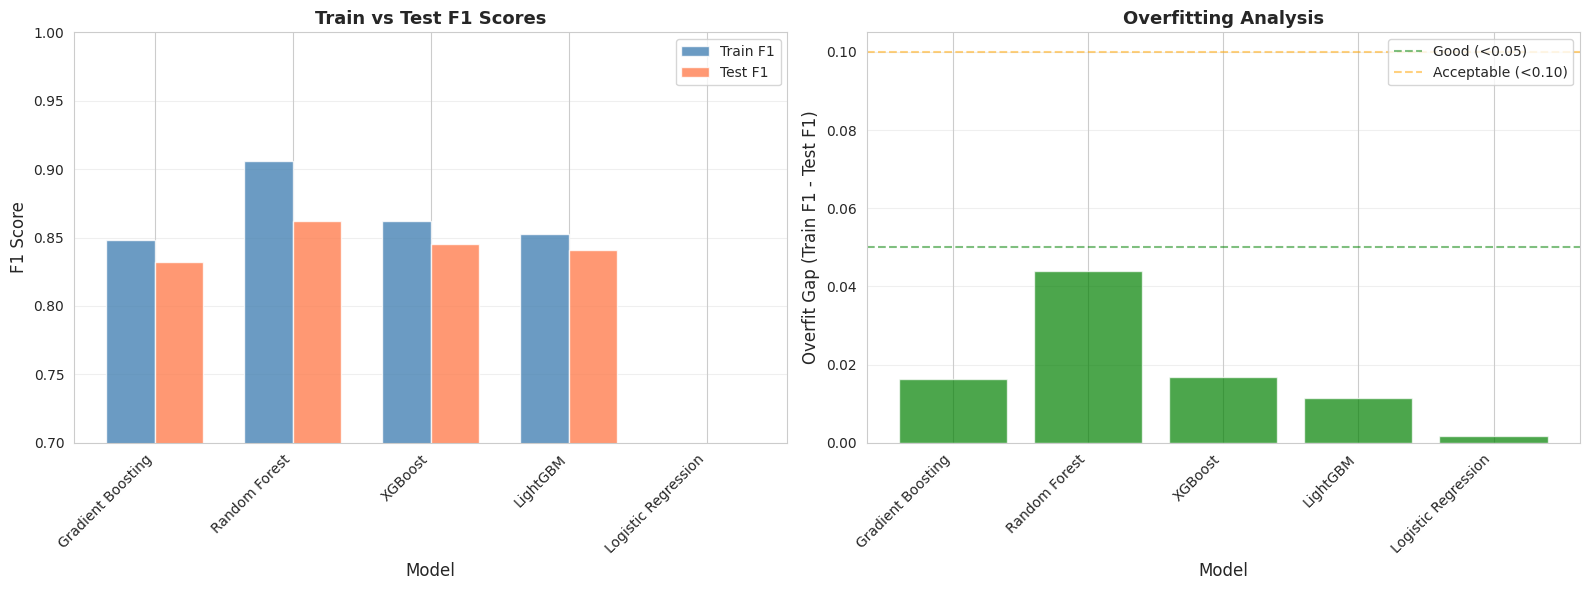

In [ ]:
print("Generating Visualizations")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: F1 Scores
x = np.arange(len(results_df))
width = 0.35

axes[0].bar(x - width/2, results_df['train_f1'], width,
            label='Train F1', alpha=0.8, color='steelblue')
axes[0].bar(x + width/2, results_df['test_f1'], width,
            label='Test F1', alpha=0.8, color='coral')
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('F1 Score', fontsize=12)
axes[0].set_title('Train vs Test F1 Scores', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df['model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim([0.7, 1.0])

# Plot 2: Overfit Gap
colors = ['green' if gap < 0.05 else 'orange' if gap < 0.10 else 'red'
          for gap in results_df['overfit_gap']]
axes[1].bar(x, results_df['overfit_gap'], color=colors, alpha=0.7)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('Overfit Gap (Train F1 - Test F1)', fontsize=12)
axes[1].set_title('Overfitting Analysis', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df['model'], rotation=45, ha='right')
axes[1].axhline(y=0.05, color='green', linestyle='--', alpha=0.5, label='Good (<0.05)')
axes[1].axhline(y=0.10, color='orange', linestyle='--', alpha=0.5, label='Acceptable (<0.10)')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [ ]:
trained_models = results_df.nlargest(5, 'test_f1')['model'].tolist()

for i, model_name in enumerate(trained_models, 1):
    model_f1 = results_df[results_df['model'] == model_name]['test_f1'].values[0]
    print(f"  {i}. {model_name:<25} (Test F1: {model_f1:.4f})")

  1. Random Forest             (Test F1: 0.8622)
  2. XGBoost                   (Test F1: 0.8453)
  3. LightGBM                  (Test F1: 0.8413)
  4. Gradient Boosting         (Test F1: 0.8320)
  5. Logistic Regression       (Test F1: 0.6632)


In [ ]:
def plot_detailed_learning_curve(model, X, y, model_name, cv=5):
    """
    Creates detailed learning curve with comprehensive plateau analysis
    """
    max_train_samples = int(len(X) * (cv - 1) / cv)
    train_sizes = np.arange(2000, max_train_samples + 1, 2000)
    train_sizes = train_sizes[train_sizes <= max_train_samples]

    print(f"Generating learning curve for {model_name}")
    print(f"Total samples: {len(X)}, Max training per fold: {max_train_samples}")
    print(f"Testing {len(train_sizes)} different training sizes")

    train_sizes_abs, train_scores, val_scores = learning_curve(
        model, X, y,
        train_sizes=train_sizes,
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    # SUBPLOT 1: Learning Curve
    ax1.plot(train_sizes_abs, train_mean, 'o-', color='#2E86AB',
            label='Training score', linewidth=2.5, markersize=8)
    ax1.plot(train_sizes_abs, val_mean, 'o-', color='#A23B72',
            label='Validation score', linewidth=2.5, markersize=8)

    ax1.fill_between(train_sizes_abs,
                     train_mean - train_std, train_mean + train_std,
                     alpha=0.15, color='#2E86AB')
    ax1.fill_between(train_sizes_abs,
                     val_mean - val_std, val_mean + val_std,
                     alpha=0.15, color='#A23B72')

    # Plateau detection
    improvements = np.diff(val_mean)
    plateau_threshold = 0.01
    plateau_detected = False
    plateau_idx = None

    if len(improvements) >= 2:
        if np.all(improvements[-2:] < plateau_threshold):
            plateau_idx = len(val_mean) - 2
            plateau_detected = True

    ax1.set_xlabel('Training Set Size', fontsize=13, fontweight='bold')
    ax1.set_ylabel('F1 Score', fontsize=13, fontweight='bold')
    ax1.set_title(f'Learning Curve: {model_name}', fontsize=15, fontweight='bold')
    ax1.legend(loc='lower right', fontsize=11, framealpha=0.9)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.set_ylim([0.5, 1.0])
    ax1.set_xlim([0, train_sizes_abs[-1] * 1.05])

    # Add reference lines
    ax1.axhline(y=0.7, color='gray', linestyle=':', alpha=0.3, linewidth=1)
    ax1.axhline(y=0.8, color='gray', linestyle=':', alpha=0.3, linewidth=1)
    ax1.axhline(y=0.9, color='gray', linestyle=':', alpha=0.3, linewidth=1)

    # SUBPLOT 2: Improvement Rate Analysis
    if len(improvements) > 0:
        ax2.plot(train_sizes_abs[1:], improvements, 'o-',
                color='#F18F01', linewidth=2.5, markersize=8,
                label='Improvement per step')
        ax2.fill_between(train_sizes_abs[1:], 0, improvements,
                        alpha=0.3, color='#F18F01')

        ax2.set_xlabel('Training Set Size', fontsize=13, fontweight='bold')
        ax2.set_ylabel('F1 Improvement', fontsize=13, fontweight='bold')
        ax2.set_title(f'Improvement Rate: {model_name}', fontsize=15, fontweight='bold')
        ax2.legend(loc='upper right', fontsize=11)
        ax2.grid(True, alpha=0.3, linestyle='--')
        ax2.set_xlim([0, train_sizes_abs[-1] * 1.05])

    plt.tight_layout()
    plt.show()


    print(f"\n{'Size':>8} | {'Train F1':>10} | {'Val F1':>10} | {'Gap':>10} | {'Improvement':>12} | {'% Change':>10}")
    print("-" * 75)
    for i, (size, train_f1, val_f1) in enumerate(zip(train_sizes_abs, train_mean, val_mean)):
        gap = train_f1 - val_f1
        improvement = val_f1 - val_mean[i-1] if i > 0 else 0
        pct_change = (improvement / val_mean[i-1] * 100) if i > 0 else 0
        print(f"{size:>8} | {train_f1:>10.4f} | {val_f1:>10.4f} | {gap:>10.4f} | {improvement:>+12.4f} | {pct_change:>+9.2f}%")

    # Overall statistics
    total_improvement = val_mean[-1] - val_mean[0]
    peak_f1 = val_mean.max()
    peak_idx = val_mean.argmax()
    final_gap = train_mean[-1] - val_mean[-1]


    return train_sizes_abs, train_mean, val_mean, train_std, val_std


Generating learning curve for Random Forest
Total samples: 54985, Max training per fold: 43988
Testing 21 different training sizes


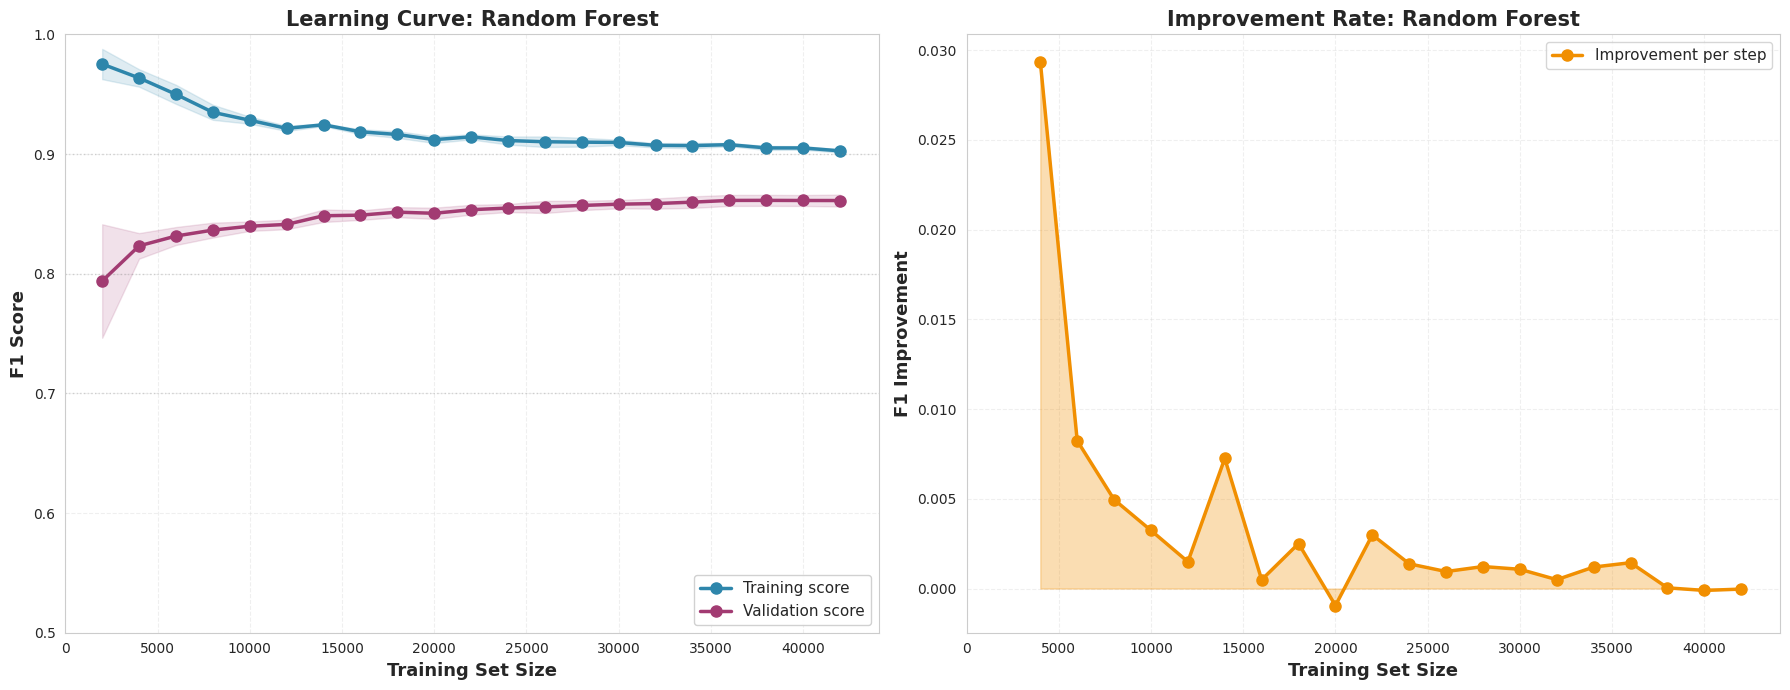


    Size |   Train F1 |     Val F1 |        Gap |  Improvement |   % Change
---------------------------------------------------------------------------
    2000 |     0.9752 |     0.7939 |     0.1813 |      +0.0000 |     +0.00%
    4000 |     0.9636 |     0.8232 |     0.1403 |      +0.0294 |     +3.70%
    6000 |     0.9499 |     0.8315 |     0.1184 |      +0.0082 |     +1.00%
    8000 |     0.9348 |     0.8364 |     0.0984 |      +0.0050 |     +0.60%
   10000 |     0.9282 |     0.8397 |     0.0886 |      +0.0032 |     +0.39%
   12000 |     0.9214 |     0.8412 |     0.0803 |      +0.0015 |     +0.18%
   14000 |     0.9244 |     0.8484 |     0.0760 |      +0.0073 |     +0.86%
   16000 |     0.9186 |     0.8489 |     0.0697 |      +0.0005 |     +0.06%
   18000 |     0.9163 |     0.8514 |     0.0649 |      +0.0025 |     +0.30%
   20000 |     0.9120 |     0.8505 |     0.0615 |      -0.0009 |     -0.11%
   22000 |     0.9143 |     0.8535 |     0.0609 |      +0.0030 |     +0.35%
   24000 | 

In [ ]:
model_1 = models[trained_models[0]]
sizes_1, train_mean_1, val_mean_1, train_std_1, val_std_1 = plot_detailed_learning_curve(
    model_1,
    df_clean[expected_features].values,
    df_clean['is_ai'].values,
    trained_models[0],
)

Generating learning curve for XGBoost
Total samples: 54985, Max training per fold: 43988
Testing 21 different training sizes


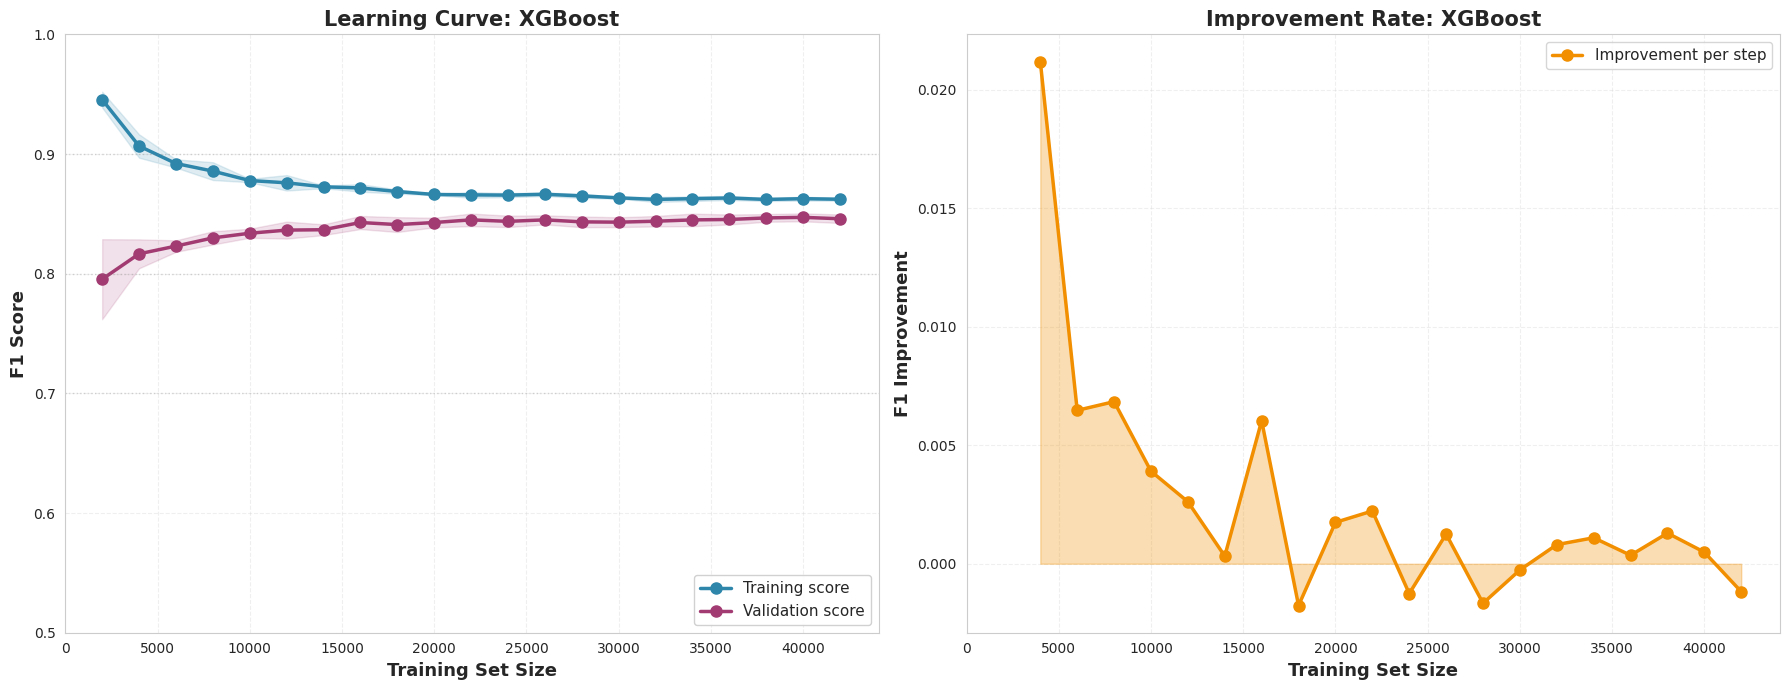


    Size |   Train F1 |     Val F1 |        Gap |  Improvement |   % Change
---------------------------------------------------------------------------
    2000 |     0.9454 |     0.7954 |     0.1500 |      +0.0000 |     +0.00%
    4000 |     0.9067 |     0.8166 |     0.0901 |      +0.0212 |     +2.66%
    6000 |     0.8921 |     0.8231 |     0.0690 |      +0.0065 |     +0.79%
    8000 |     0.8857 |     0.8299 |     0.0558 |      +0.0068 |     +0.83%
   10000 |     0.8778 |     0.8338 |     0.0440 |      +0.0039 |     +0.47%
   12000 |     0.8759 |     0.8364 |     0.0395 |      +0.0026 |     +0.31%
   14000 |     0.8726 |     0.8367 |     0.0358 |      +0.0003 |     +0.04%
   16000 |     0.8717 |     0.8428 |     0.0289 |      +0.0060 |     +0.72%
   18000 |     0.8686 |     0.8410 |     0.0276 |      -0.0018 |     -0.21%
   20000 |     0.8662 |     0.8428 |     0.0234 |      +0.0017 |     +0.21%
   22000 |     0.8658 |     0.8450 |     0.0209 |      +0.0022 |     +0.26%
   24000 | 

In [ ]:
model_2 = models[trained_models[1]]
sizes_2, train_mean_2, val_mean_2, train_std_2, val_std_2 = plot_detailed_learning_curve(
    model_2,
    df_clean[expected_features].values,
    df_clean['is_ai'].values,
    trained_models[1],
)